In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
train_path = "/content/drive/MyDrive/AA_MEB/v2_multiclass_moreBalanced_dataset/train/"
val_path = "/content/drive/MyDrive/AA_MEB/v2_multiclass_moreBalanced_dataset/val/"
test_path = "/content/drive/MyDrive/AA_MEB/v2_multiclass_moreBalanced_dataset/test/"

train_dataset = torchvision.datasets.ImageFolder(train_path, transform = transform)
val_dataset = torchvision.datasets.ImageFolder(val_path, transform = transform)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform = transform)

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

In [6]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [7]:
get_mean_and_std(train_loader)

(tensor([0.1648, 0.1134, 0.0961]), tensor([0.3061, 0.2211, 0.1941]))

In [8]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(85),
                                transforms.Normalize((0.1654, 0.1139, 0.0965),
                                                     (0.3065, 0.2217, 0.1946))])

In [9]:
train_path = "/content/drive/MyDrive/AA_MEB/v2_multiclass_moreBalanced_dataset/train/"
val_path = "/content/drive/MyDrive/AA_MEB/v2_multiclass_moreBalanced_dataset/val/"
test_path = "/content/drive/MyDrive/AA_MEB/v2_multiclass_moreBalanced_dataset/test/"

train_dataset = torchvision.datasets.ImageFolder(train_path, transform = transform)
val_dataset = torchvision.datasets.ImageFolder(val_path, transform = transform)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform = transform)


In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

In [11]:
print("training set contains:", len(train_dataset), "images")
print("validation set contains:", len(val_dataset), "images")
print("testing set contains:", len(test_dataset), "images")

training set contains: 822 images
validation set contains: 112 images
testing set contains: 114 images


In [12]:
print(train_dataset.class_to_idx)

{'keratosis': 0, 'melanoma': 1, 'neither': 2}


In [13]:
images, labels = next(iter(train_loader))

images.shape # [batch_size, color_channels, height, width]

torch.Size([32, 3, 200, 200])

In [14]:
print("Number of images in training set: {}".format(len(train_dataset)))
print("Number of images in test set: {}".format(len(val_dataset)))
print("Number of images in test set: {}".format(len(test_dataset)))

print("...")

print("Number of batches in the train loader: {}".format(len(train_loader)))
print("Number of batches in the test loader: {}".format(len(val_loader)))
print("Number of batches in the test loader: {}".format(len(test_loader)))

Number of images in training set: 822
Number of images in test set: 112
Number of images in test set: 114
...
Number of batches in the train loader: 26
Number of batches in the test loader: 4
Number of batches in the test loader: 4


In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
            
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=18, kernel_size=3, stride=1), # 382x382x16
            nn.BatchNorm2d(18),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2), #191x192x16

            nn.Conv2d(in_channels=18, out_channels=36, kernel_size=3, stride=1),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        
            nn.Conv2d(in_channels=36, out_channels=54, kernel_size=3, stride=1),
            nn.BatchNorm2d(54),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        
        self.fc_model = nn.Sequential(
            nn.Linear(28566,10024),
            nn.BatchNorm1d(10024),
            nn.ReLU(),
            nn.Linear(10024,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024,3))

    def forward(self, x):
        #print(x.shape)
        out = self.cnn_model(x)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        #nn.Flatten(),
        #print(out.shape)
        out = self.fc_model(out)
        #print(out)
        return out

In [16]:
CUDA = torch.cuda.is_available()

if CUDA:
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [17]:
criterion=nn.CrossEntropyLoss()

model = CNN().to(device)
optimizer=torch.optim.SGD(model.parameters(), lr=1e-3)

In [18]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

In [19]:
import numpy as np

epochs = 30
min_valid_loss = np.inf

train_loss_values = []
valid_loss_values = []
train_acc = []
val_acc = []

for e in range(epochs):
    train_loss = []
    running_train_accuracy = 0.00

    model.train()     # Optional when not using Model Specific layer
    size = len(train_loader.dataset)
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
            batch, c, h, w = data.shape 
        
        optimizer.zero_grad()
        predictions = model(data)
        t_loss = criterion(predictions,labels)
        t_loss.backward()
        optimizer.step()
        train_loss.append(t_loss.item())

        running_train_accuracy += accuracy(predictions, labels)

    running_train_accuracy /= len(train_loader)
    train_acc.append(running_train_accuracy.cpu())

    train_loss_values.append(np.array(train_loss).mean())

    valid_loss = []
    
    model.eval()     # Optional when not using Model Specific layer
    running_val_accuracy = 0.00
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        predictions = model(data)
        v_loss = criterion(predictions,labels)
        valid_loss.append(v_loss.item())
        running_val_accuracy += accuracy(predictions, labels)

    running_val_accuracy /= len(val_loader)

    valid_loss_values.append(np.array(valid_loss).mean())
    val_acc.append(running_val_accuracy.cpu())

    print(f'Epoch {e+1} \t\t Training Loss: {t_loss.item()} \t\t Validation Loss: {v_loss.item()}')
    print(f'Metrics \t\t Training accuracy: {running_train_accuracy} \t\t Validation accuracy: {running_val_accuracy}') 
        
        
    # Saving State Dict
    torch.save(model.state_dict(), '01_model.pth')

Epoch 1 		 Training Loss: 0.8407726287841797 		 Validation Loss: 1.1984310150146484
Metrics 		 Training accuracy: 0.472027987241745 		 Validation accuracy: 0.34375
Epoch 2 		 Training Loss: 1.0964466333389282 		 Validation Loss: 0.8734256625175476
Metrics 		 Training accuracy: 0.5464379191398621 		 Validation accuracy: 0.546875
Epoch 3 		 Training Loss: 0.94796222448349 		 Validation Loss: 0.9517500400543213
Metrics 		 Training accuracy: 0.5835883021354675 		 Validation accuracy: 0.546875
Epoch 4 		 Training Loss: 0.7390250563621521 		 Validation Loss: 1.0495564937591553
Metrics 		 Training accuracy: 0.6121066808700562 		 Validation accuracy: 0.484375
Epoch 5 		 Training Loss: 0.6415578722953796 		 Validation Loss: 0.9708107709884644
Metrics 		 Training accuracy: 0.6325393319129944 		 Validation accuracy: 0.5078125
Epoch 6 		 Training Loss: 0.9199981093406677 		 Validation Loss: 0.8545504212379456
Metrics 		 Training accuracy: 0.6123251914978027 		 Validation accuracy: 0.6015625
Epoch 

Text(0, 0.5, 'loss')

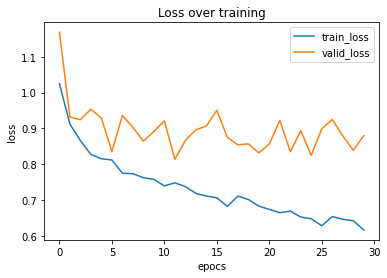

In [26]:
plt.title("Loss over training")
plt.plot(train_loss_values)
plt.plot(valid_loss_values)
plt.legend(["train_loss", "valid_loss"])
plt.xlabel("epocs")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

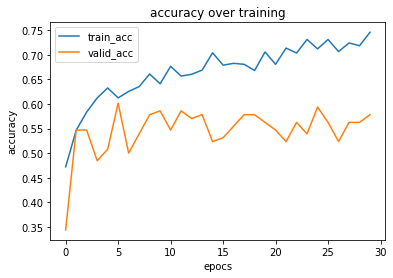

In [27]:
plt.title("accuracy over training")
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["train_acc", "valid_acc"])
plt.xlabel("epocs")
plt.ylabel("accuracy")

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import recall_score, accuracy_score, classification_report

In [29]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

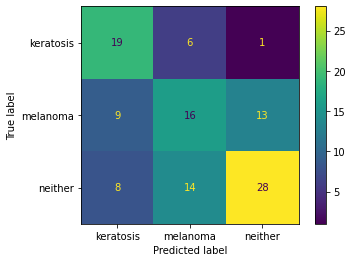

In [30]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.class_to_idx)
disp.plot()

In [31]:
cr = classification_report(y_true, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.53      0.73      0.61        26
           1       0.44      0.42      0.43        38
           2       0.67      0.56      0.61        50

    accuracy                           0.55       114
   macro avg       0.55      0.57      0.55       114
weighted avg       0.56      0.55      0.55       114

